# **U2-Net**

A Pytorch implementation of U2-Net: Going Deeper with Nested U−Structure for Salient Object Detection  
  
**Dataset:** CelebA Mask HQ

**Reference:**  
https://araseo08.tistory.com/4  
https://victordibia.com/blog/u-2-net/  

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import random
import itertools

## Hyperparameters

In [ ]:
img_size = 128

batch_size = 12
valid_batch_size = 50
epochs = 25
n_print = 100
lr = 0.001

workers = 2
isCuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True
print("Device: {}".format(device))

model_saved_dir = "/content/drive/MyDrive/Colab Notebooks/U2Net"

Device: cuda:0


## Dataset

In [ ]:
# Download custom dataset from kaggle
import os.path

if os.path.isfile('~/.kaggle/kaggle.json'):
  print("Already kaggle.json exsits.")
else:
  !mkdir -p ~/.kaggle
  !cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kimjiyeop/celeba-128-onlybg
if os.path.isdir('./CelebA-img'):
  print("Already unzip.")
else:
  !unzip -q celeba-128-onlybg.zip
  print("Unzip Complete!")

100% 353M/353M [00:11<00:00, 52.4MB/s]
100% 353M/353M [00:11<00:00, 33.1MB/s]
Unzip Complete!


In [ ]:
class CelebAwithMask(torch.utils.data.Dataset):
  def __init__(self, split, transform=None):
    rng = {'train':(0,27000), 'valid':(27000,29500), 'test':(29500,30000)}
    s, e = rng[split]
    self.nums = [i for i in range(s, e)]
    self.transform = transform
        
  def __getitem__(self, index):
    num = self.nums[index]
    transform = transforms.Compose([transforms.ToTensor()])

    img = cv2.imread('./CelebA-img/{}.jpg'.format(num))
    if self.transform:
      img = self.transform(img)

    mask = cv2.imread('./CelebA-mask/{}.jpg'.format(num), cv2.IMREAD_GRAYSCALE)
    mask = transform(mask).squeeze(0)

    return img, mask

  def __len__(self):
    return len(self.nums)

# Restore images to suitable images of opencv style
def ImgForPlot(img):
  img = np.einsum('ijk->jki', img)
  img = (127.5*(img+1)).astype(np.uint8)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
dataset = CelebAwithMask(split='train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

valid_dataset = CelebAwithMask(split='valid', transform=transform)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, num_workers=workers)

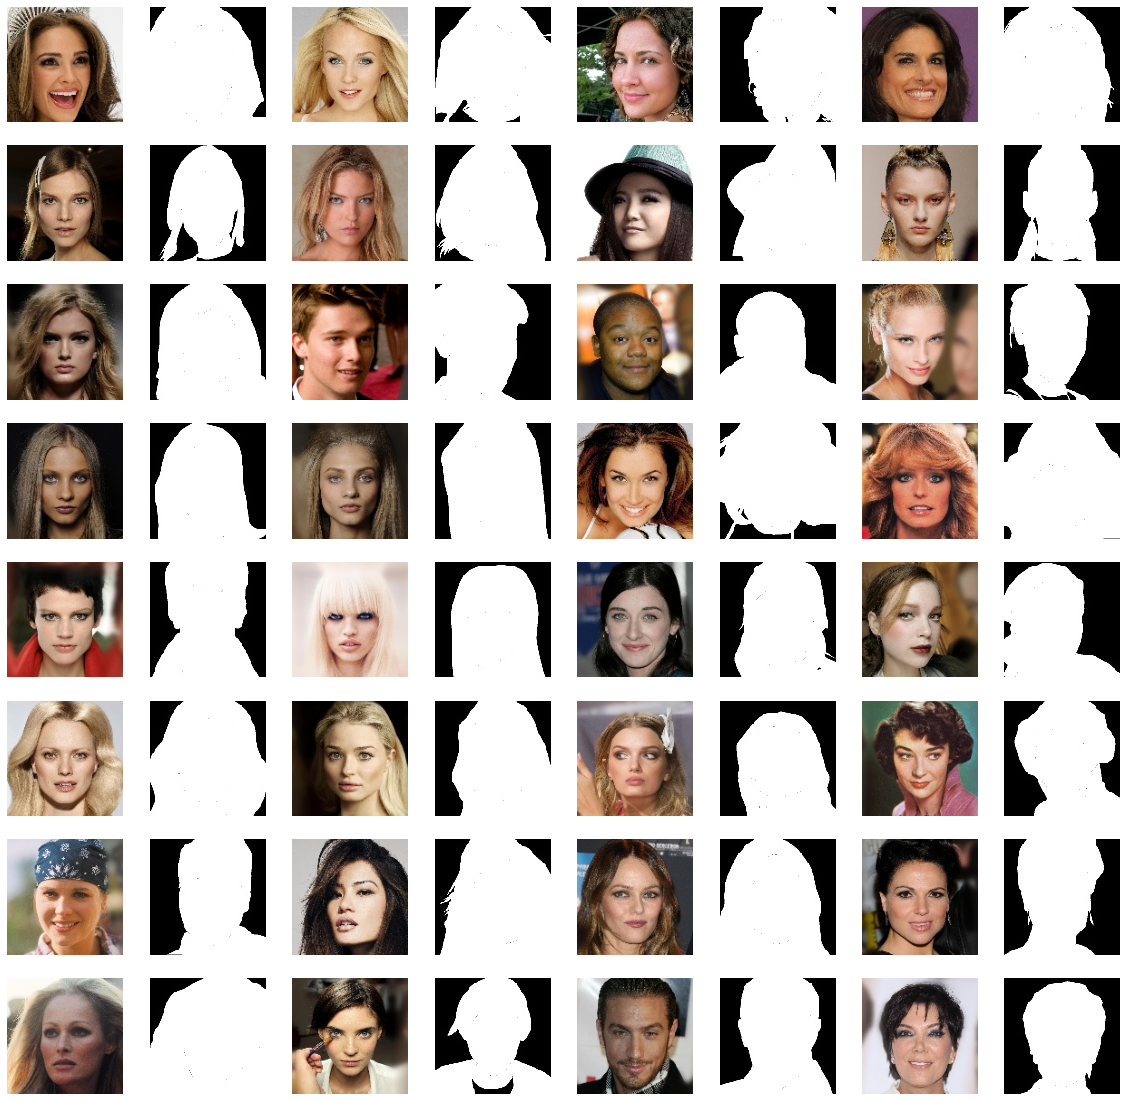

In [ ]:
fig = plt.figure(figsize=(20,20))

for k in range(32):
    img, mask = dataset[k]
    ax = fig.add_subplot(8, 8, 2*k+1)
    ax.imshow(ImgForPlot(img))
    ax.axis("off")
    ax = fig.add_subplot(8, 8, 2*k+2)
    ax.imshow(mask, cmap='gray', vmin=0, vmax=1, interpolation='none')
    ax.axis("off")

plt.show()

## Model

In [ ]:
def init_weight(layer):
    nn.init.xavier_uniform_(layer.weight)
    if layer.bias is not None:
        nn.init.constant_(layer.bias, 0)

### Conv + BN + ReLU

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channel, out_channel, dilation=1):
    super(ConvBlock, self).__init__()
    self.conv = nn.Conv2d(in_channel, out_channel, 3, stride=1, padding=dilation, dilation=dilation)
    self.bn = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU(inplace = True)
    init_weight(self.conv)

  def forward(self, x):
    return self.relu(self.bn(self.conv(x)))

### RSU

In [ ]:
class RSU(nn.Module):
  def __init__(self, L, C_in, C_out, M):
    super(RSU, self).__init__()
    self.conv = ConvBlock(C_in, C_out)
    
    self.enc = nn.ModuleList([ConvBlock(C_out, M)])
    for i in range(L-2):
      self.enc.append(ConvBlock(M, M))
    
    self.mid = ConvBlock(M, M, dilation=2)

    self.dec = nn.ModuleList([ConvBlock(2*M, M) for i in range(L-2)])
    self.dec.append(ConvBlock(2*M, C_out))

    self.downsample = nn.MaxPool2d(2, stride=2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

  def forward(self, x):
    x = self.conv(x)
    
    out = []
    for i, enc in enumerate(self.enc):
      if i == 0: out.append(enc(x))
      else: out.append(enc(self.downsample(out[i-1])))
    
    y = self.mid(out[-1])

    for i, dec in enumerate(self.dec):
      if i > 0: y = self.upsample(y)
      y = dec(torch.cat((out[len(self.dec)-i-1], y), dim=1))
    
    return x + y

### RSU4F

In [ ]:
class RSU4F(nn.Module):
  def __init__(self, C_in, C_out, M):
    super(RSU4F, self).__init__()
    self.conv = ConvBlock(C_in, C_out)
    
    self.enc = nn.ModuleList([
      ConvBlock(C_out, M),
      ConvBlock(M, M, dilation=2),
      ConvBlock(M, M, dilation=4)
    ])
    
    self.mid = ConvBlock(M, M, dilation=8)

    self.dec = nn.ModuleList([
      ConvBlock(2*M, M, dilation=4),
      ConvBlock(2*M, M, dilation=2),
      ConvBlock(2*M, C_out)
    ])

  def forward(self, x):
    x = self.conv(x)
    
    out = []
    for i, enc in enumerate(self.enc):
      if i == 0: out.append(enc(x))
      else: out.append(enc(out[i-1]))
    
    y = self.mid(out[-1])

    for i, dec in enumerate(self.dec):
      y = dec(torch.cat((out[len(self.dec)-i-1], y), dim=1))
    
    return x + y

### U2-Net

In [ ]:
class U2Net(nn.Module):
  def __init__(self):
    super(U2Net, self).__init__()
    self.enc = nn.ModuleList([
      RSU(L=7, C_in=3, C_out=64, M=32),
      RSU(L=6, C_in=64, C_out=128, M=32),
      RSU(L=5, C_in=128, C_out=256, M=64),
      RSU(L=4, C_in=256, C_out=512, M=128),
      RSU4F(C_in=512, C_out=512, M=256),
      RSU4F(C_in=512, C_out=512, M=256)
    ])

    self.dec = nn.ModuleList([
      RSU4F(C_in=1024, C_out=512, M=256),
      RSU(L=4, C_in=1024, C_out=256, M=128),
      RSU(L=5, C_in=512, C_out=128, M=64),
      RSU(L=6, C_in=256, C_out=64, M=32),
      RSU(L=7, C_in=128, C_out=64, M=16)
    ])

    self.convs = nn.ModuleList([
      nn.Conv2d(64, 1, 3, padding=1),
      nn.Conv2d(64, 1, 3, padding=1),
      nn.Conv2d(128, 1, 3, padding=1),
      nn.Conv2d(256, 1, 3, padding=1),
      nn.Conv2d(512, 1, 3, padding=1),
      nn.Conv2d(512, 1, 3, padding=1)
    ])

    self.lastconv = nn.Conv2d(6, 1, 1)
    self.downsample = nn.MaxPool2d(2, stride=2)

    init_weight(self.lastconv)
    for conv in self.convs:
      init_weight(conv)

  def upsample(self, x, target):
    return F.interpolate(x, size=target.shape[2:], mode='bilinear')

  def forward(self, x):
    enc_out = []
    for i, enc in enumerate(self.enc):
      if i == 0: enc_out.append(enc(x))
      else: enc_out.append(enc(self.downsample(enc_out[i-1])))

    dec_out = [enc_out[-1]]
    for i, dec in enumerate(self.dec):
      dec_out.append(dec(torch.cat((self.upsample(dec_out[i], enc_out[4-i]), enc_out[4-i]), dim=1)))
    
    side_out = []
    for i, conv in enumerate(self.convs):
      if i == 0: side_out.append(conv(dec_out[5]))
      else: side_out.append(self.upsample(conv(dec_out[5-i]), side_out[0]))
    
    side_out.append(self.lastconv(torch.cat(side_out, dim=1)))       

    return [torch.sigmoid(s.squeeze(1)) for s in side_out]

## Training

In [ ]:
model = U2Net().cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

### (Option) Load Model

In [ ]:
model_name = 'u2net-celebamask'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"

with open(loss_path, 'rb') as f:
  losses = pickle.load(f)

model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Training Model

In [ ]:
model_name = 'u2net-celebamask'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
best_model_path = F"{model_saved_dir}/{model_name}_best.pt"
model_path = F"{model_saved_dir}/{model_name}.pt"

start_epoch = 0

if start_epoch == 0:
  losses = {'train': [[], [], [], [], [], [], []],
            'valid': []}
  best_loss = float("inf")
else:
  best_loss = min(losses['valid'])

BCE = nn.BCELoss(reduction='mean')  # Train
MAE = nn.L1Loss(reduction='mean')   # Validation

step, loss_sum_train, loss_sum_valid = 0, 0., 0.

for ep in range(start_epoch, epochs):
  for batch_idx, (input, target) in enumerate(dataloader, 0):
    input = input.cuda()
    target = target.cuda()
    step += 1
    
    # Train Model
    model.train()
    optimizer.zero_grad()
    
    out = model(input)
    each_loss = [BCE(o, target) for o in out]
    loss = sum(each_loss)
    
    loss.backward()
    optimizer.step()

    # Append Losses
    for i, l in enumerate(each_loss):
      losses['train'][i].append(l.item())

    # Evaluate Model
    model.eval()
    with torch.no_grad():
      input, target = next(iter(valid_dataloader))
      out = model(input.cuda())[-1]
      val_loss = MAE(out, target.cuda())
      losses['valid'].append(val_loss.item())
      if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        torch.save(model.state_dict(), best_model_path)
    
    loss_sum_train += loss.item()
    loss_sum_valid += val_loss.item()

    if batch_idx % n_print == (n_print-1) or batch_idx == (len(dataloader)-1):
      print('[%2d/%2d][%4d/%4d]' % (ep+1, epochs, batch_idx+1, len(dataloader)))
      print('\tTrain: %.4f / Valid: %.4f (Best: %.4f)' % (loss_sum_train/step, loss_sum_valid/step, best_loss))
      print('\tDetails: %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f' % tuple([sum(l[-step:])/step for l in losses['train']]))
      step, loss_sum_train, loss_sum_valid = 0, 0., 0.
      

  torch.save(model.state_dict(), model_path)
  with open(loss_path, 'wb') as f:
      pickle.dump(losses, f)
  
  print("Saved model completely!")

## Loss

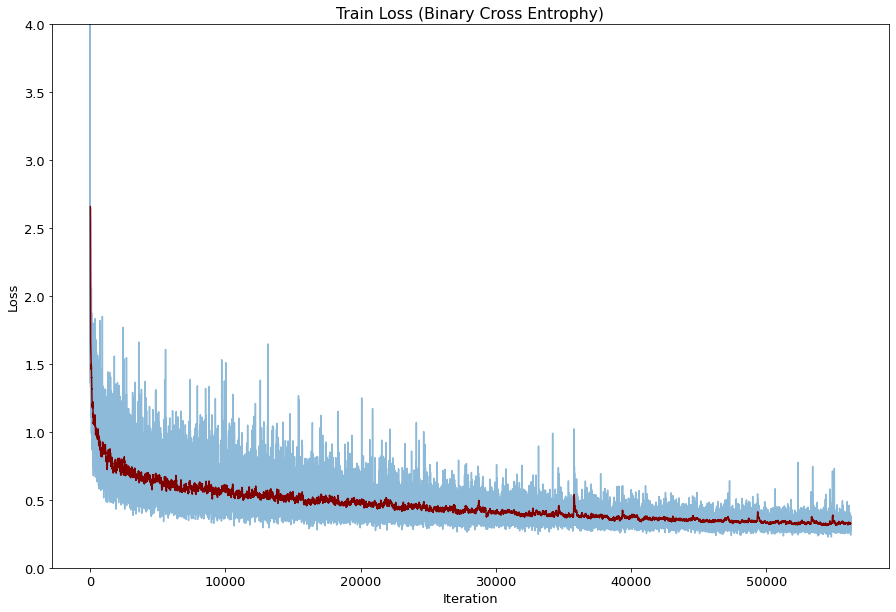

In [ ]:
import matplotlib

matplotlib.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(15,10))

N = len(losses['train'][0])
y = []
for i in range(N):
  y.append(sum([losses['train'][j][i] for j in range(6)]))

K = 25
avg = []
for i in range(K, N-K):
  avg.append(sum(y[(i-K):(i+K+1)])/(2*K+1))
  
plt.plot(range(N), y, alpha=0.5)
plt.plot(range(K, N-K), avg, 'maroon')
plt.ylim(0, 4)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss (Binary Cross Entrophy)')
#plt.show()
plt.savefig('train_loss.png')

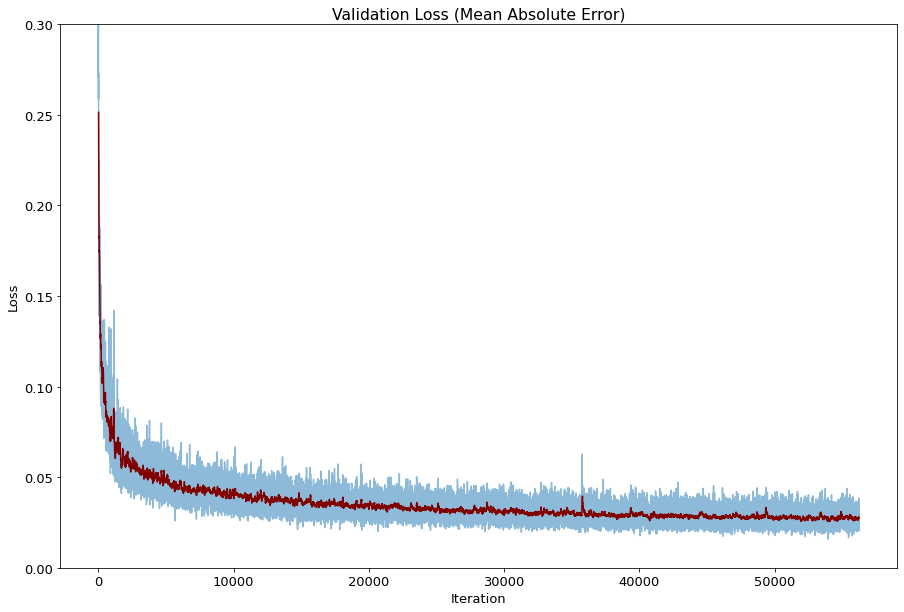

In [ ]:
fig = plt.figure(figsize=(15,10))
y = losses['valid']
N = len(y)

K = 25
avg = []
for i in range(K, N-K):
  avg.append(sum(y[(i-K):(i+K+1)])/(2*K+1))
  
plt.plot(range(N), y, alpha=0.5)
plt.plot(range(K, N-K), avg, 'maroon')
plt.ylim(0, 0.3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Validation Loss (Mean Absolute Error)')
#plt.show()
plt.savefig('val_loss.png')

## Test

In [ ]:
test_dataset = CelebAwithMask(split='test', transform=transform)

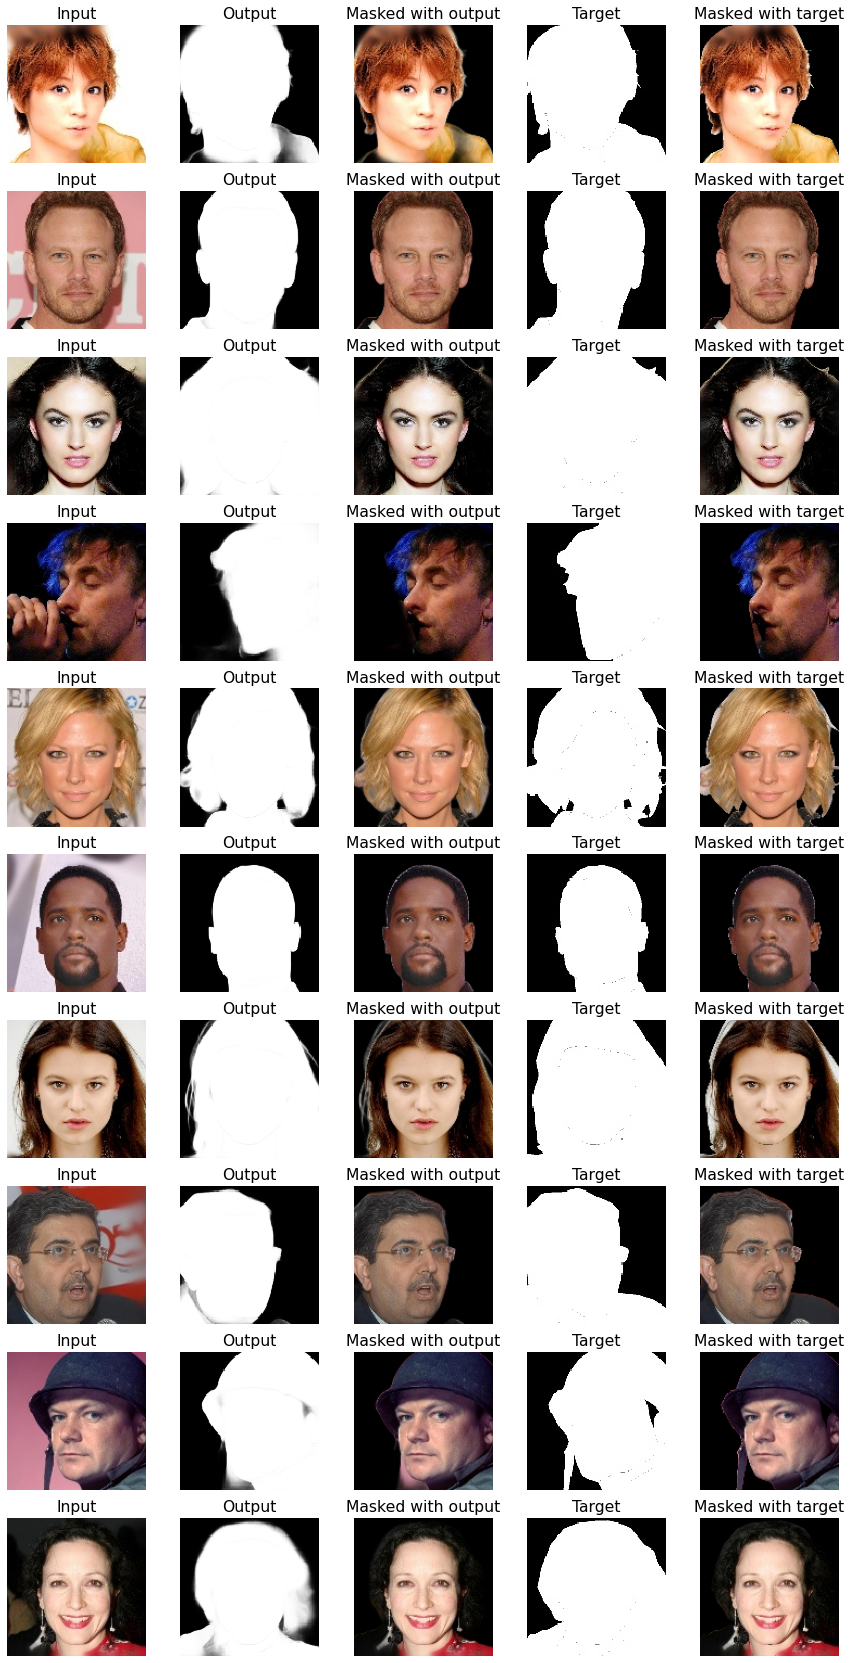

In [ ]:
def maskedImage(img, mask):
  img = img.cpu()
  img = np.einsum('ijk->jki', img)
  img = (127.5*(img+1)).astype(np.uint8)
  mask = mask.unsqueeze(2).detach().cpu().numpy()
  return cv2.cvtColor((img * mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=workers)

input, target = next(iter(test_dataloader))
input = input.cuda()
target = target.cuda()
mask = model(input)[-1]

fig = plt.figure(figsize=(15, 30))
for k in range(10):
    ax = fig.add_subplot(10, 5, 5*k+1)
    ax.imshow(ImgForPlot(input[k].cpu()))
    ax.set_title('Input')
    ax.axis("off")

    ax = fig.add_subplot(10, 5, 5*k+2)
    ax.imshow(mask[k].detach().cpu(), cmap='gray', vmin=0, vmax=1, interpolation='none')
    ax.set_title('Output')
    ax.axis("off")

    ax = fig.add_subplot(10, 5, 5*k+3)
    ax.imshow(maskedImage(input[k], mask[k]))
    ax.set_title('Masked with output')
    ax.axis("off")

    ax = fig.add_subplot(10, 5, 5*k+4)
    ax.imshow(target[k].detach().cpu(), cmap='gray', vmin=0, vmax=1, interpolation='none')
    ax.set_title('Target')
    ax.axis("off")
    
    ax = fig.add_subplot(10, 5, 5*k+5)
    ax.imshow(maskedImage(input[k], target[k]))
    ax.set_title('Masked with target')
    ax.axis("off")

plt.savefig('result.png')

In [79]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers=workers)

test_loss = 0.
model.eval()
with torch.no_grad():
  for i in range(len(test_dataloader)):
    input, target = next(iter(test_dataloader))
    out = model(input.cuda())[-1]
    test_loss += MAE(out, target.cuda()).item() / len(test_dataloader)

print(test_loss)

0.02649154867976904
